In [1]:
using Revise, QARBoM, DWave, DataFrames, CSV

In [7]:
MOI = QARBoM.QUBO.ToQUBO.MOI

MathOptInterface

In [2]:
df = DataFrame(CSV.File(raw"./converted_bool_only.csv"))

x_train = Vector{Vector{Int}}()

for row in eachrow(df)
    push!(x_train, collect(row))
end

In [3]:
learning_rates = [i for i in range(0.001, 0.01, 10)]

10-element Vector{Float64}:
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01

In [27]:
W = rand(22,10)

22×10 Matrix{Float64}:
 0.334713   0.634523   0.812309    …  0.20305     0.48962      0.706122
 0.276908   0.718812   0.887869       0.328789    0.798254     0.159067
 0.78263    0.142855   0.606646       0.330244    0.638734     0.64869
 0.383086   0.356634   0.615538       0.669491    0.884659     0.0783173
 0.943926   0.301364   0.629138       0.399798    0.955901     0.407083
 0.0475339  0.878673   0.891352    …  0.954839    0.783362     0.479868
 0.789541   0.837264   0.773506       0.379253    0.43197      0.401914
 0.0329159  0.0564498  0.330886       0.130549    0.137952     0.974479
 0.787996   0.363931   0.55595        0.00420498  0.0436197    0.761063
 0.159633   0.812253   0.118708       0.0239262   0.963019     0.888473
 0.640716   0.31692    0.186337    …  0.622935    0.000789008  0.637243
 0.100858   0.285438   0.202447       0.0438384   0.533058     0.632249
 0.357927   0.414044   0.725604       0.336599    0.0148079    0.944241
 0.120413   0.970963   0.984622       0.4

In [28]:
MOI.supports(::DWave.Neal.Optimizer, ::MOI.ObjectiveSense) = true
function setup_dwave(model, sampler)
    MOI.set(model, MOI.RawOptimizerAttribute("num_reads"), 25)
    MOI.set(model, MOI.RawOptimizerAttribute("num_sweeps"), 75)
end

setup_dwave (generic function with 1 method)

In [29]:
all_mse = []

Any[]

In [30]:
for learning_rate in learning_rates
    rbm =  RBM(22,10, W)

    println()
    println("Learning rate $(learning_rate)") 
    println()

    mse = QARBoM.train_persistent_qubo!(
        rbm, 
        x_train[1:10000];
        batch_size = 10, 
        n_epochs = 50,  
        learning_rate = [learning_rate for i in 1:50],
        model_setup = setup_dwave,
        sampler = DWave.Neal.Optimizer
    )

    push!(all_mse, mse)
end


Learning rate 0.001

Setting up QUBO model
Setting mini-batches
Starting training
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     1 |    8.1223 |        0.1406 |       6.5743 |        1.9181 |    8.6330 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     2 |    3.7210 |        0.0434 |       6.3347 |        2.2745 |   17.2856 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time

In [31]:
using Plots

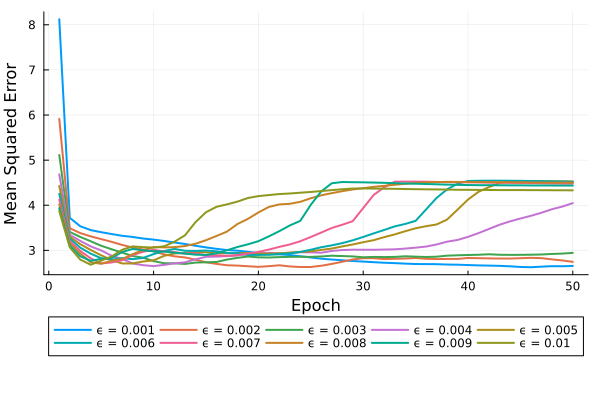

In [32]:
plot(range(1,50), [all_mse],label = permutedims(["ϵ = $lr" for lr in learning_rates]), linewidth=2)
# plot(range(1,50, length = 50), all_mse[2],label = "ϵ = 0.002")
xlabel!("Epoch")
ylabel!("Mean Squared Error")
plot!(legend=:outerbottom, legendcolumns=5)
savefig("plot_1.pdf")

In [33]:
df = DataFrame()
i = 1
for lr in learning_rates
    df[!,"$lr"] =  all_mse[i]
    i += 1
end
df

Row,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.12233,5.91462,5.11497,4.68559,4.42717,4.25474,4.12617,4.02096,3.93782,3.87195
2,3.72104,3.49201,3.4082,3.34542,3.30033,3.26202,3.20723,3.16036,3.10711,3.06981
3,3.53519,3.38319,3.2983,3.21072,3.13831,3.06057,2.98979,2.9327,2.86994,2.79614
4,3.44913,3.31068,3.20204,3.08817,3.0095,2.92813,2.82403,2.73628,2.76793,2.68227
5,3.40306,3.25013,3.10209,2.99971,2.89105,2.8252,2.71127,2.70319,2.81222,2.77118
6,3.36242,3.18884,3.02451,2.88025,2.78504,2.79534,2.73193,2.77168,2.83212,2.86663
7,3.32343,3.12101,2.95063,2.81077,2.71017,2.82768,2.78129,2.80866,2.96433,3.01343
8,3.29779,3.06223,2.87561,2.7101,2.71076,2.80566,2.89513,2.91599,3.03207,3.08833
9,3.26268,3.02055,2.83863,2.67178,2.75395,2.83219,2.96956,3.00625,3.00219,3.07158


In [34]:
# CSV.write("mse_learning_rate.csv", df)

"mse_learning_rate.csv"

In [78]:
learning_rates_2 = [i for i in range(0.0001, 0.001, 10)]

10-element Vector{Float64}:
 0.0001
 0.0002
 0.0003
 0.0004
 0.0005
 0.0006
 0.0007
 0.0008
 0.0009
 0.001

In [79]:
all_mse_2 = []

Any[]

In [80]:
for learning_rate in learning_rates_2
    rbm = QARBoM.RBM(22,10, DWave.Neal.Optimizer)
    MOI.set(rbm.model, MOI.RawOptimizerAttribute("num_reads"), 250)
    MOI.set(rbm.model, MOI.RawOptimizerAttribute("num_sweeps"), 10)

    println()
    println("Learning rate $(learning_rate)") 
    println()

    mse = QARBoM.train_persistent_qubo(rbm, x_train[1:10000];n_samples = 1, batch_size = 10, n_epochs = 50, 
        learning_rate = [learning_rate for i in 1:50])

    push!(all_mse_2, mse)
end


Learning rate 0.0001

Setting mini-batches
Starting training
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     1 |    6.5573 |        0.0207 |       9.9148 |        1.6801 |   11.6156 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsamp) | Time (Update) | Total     |
|------------------------------------------------------------------------------|
|     2 |    5.7656 |        0.1100 |       9.1626 |        1.6117 |   22.4998 |
|------------------------------------------------------------------------------|
|------------------------------------------------------------------------------|
| Epoch |    MSE    | Time (Sample) | Time (Qsa

In [93]:
plot(range(1,50), [all_mse_2],label = permutedims(["ϵ = $lr" for lr in learning_rates_2]), linewidth=2)
# plot(range(1,50, length = 50), all_mse[2],label = "ϵ = 0.002")
theme(:wong)


lens!([45, 50], [2, 3], inset = (1, bbox(0.5, 0.0, 0.4, 0.4)), subplot=2)


xlabel!("Epoch", subplot =1)
ylabel!("Mean Squared Error", subplot =1 )

plot!(legend=:outerbottom, legendcolumns=5)

savefig("plot_2.pdf")

"/Users/pripper/Documents/GitHub/RBM/example/plot_2.pdf"

In [91]:
df_2 = DataFrame()
i = 1
for lr in learning_rates_2
    df_2[!,"$lr"] =  all_mse_2[i]
    i += 1
end

In [92]:
df_2

Row,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6.55728,7.23374,5.63415,5.74397,4.67853,3.11694,3.95163,5.36716,4.89483,3.39637
2,5.76565,5.72801,4.33835,3.83559,3.27853,2.31138,2.63425,3.16188,2.64878,2.32675
3,5.10207,4.59385,3.56136,3.06226,2.76367,2.15228,2.42301,2.79569,2.32022,2.05289
4,4.56265,3.77622,3.07966,2.64869,2.55112,2.19934,2.33818,2.61959,2.35124,2.01178
5,4.1468,3.23645,2.77725,2.39657,2.48381,2.35231,2.276,2.4169,2.37845,2.05974
6,3.84501,2.89164,2.59161,2.27435,2.45722,2.4472,2.1925,2.28312,2.34842,2.08157
7,3.62493,2.66145,2.47824,2.23047,2.45559,2.42076,2.13598,2.2276,2.31414,2.15787
8,3.45643,2.51643,2.39983,2.22031,2.45752,2.41105,2.09105,2.21412,2.41274,2.18899
9,3.33077,2.4188,2.35296,2.247,2.49834,2.40776,2.10152,2.19398,2.44691,2.21664


In [94]:
# CSV.write("mse_2.csv", df_2)

"mse_2.csv"

In [2]:
df_loaded = DataFrame(CSV.File("mse_2.csv"))

LoadError: ArgumentError: "mse_2.csv" is not a valid file or doesn't exist

In [3]:
# df_to_plot = select!(df_loaded, Not(["0.0005", "0.0007", "0.0008", "0.0009", "0.001"]))
df_to_plot = select!(df_loaded, Not(["0.0002", "0.0003", "0.0004", "0.0006", "0.0007", "0.0008", "0.001"]))


LoadError: UndefVarError: `df_loaded` not defined

In [54]:
plot(Matrix(df_to_plot), labels=permutedims(string.("ϵ = " ,names(df_to_plot))), linewidth=2, botton_margin=0, right_margin = 3Plots.mm)
# plot(range(1,50, length = 50), all_mse[2],label = "ϵ = 0.002")
theme(:wong)


lens!([45, 50], [2, 3], inset = (1, bbox(0.5, 0.0, 0.4, 0.4)), subplot=2)


xlabel!("Epoch", subplot =1)
ylabel!("Mean Squared Error", subplot =1 )

plot!(legend=:outerbottom, legendcolumns=3)

savefig("errors.pdf")

"D:\\git\\RBM\\example\\errors.pdf"